# Breakpoints - Approval mechanism

## Define ReAct Agent

In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

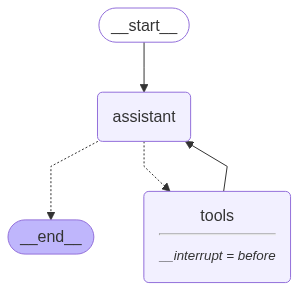

In [2]:
# Build agent

# Tool definitions

def multiply(a: int, b: int) -> int:
    """
        Function to multiply 2 given numbers
        The return value is an integer which is the product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """
        Function to add 2 given numbers
        The return value is an integer which is the sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
        Function to subtract 2 given numbers
        The return value is an integer which is the difference of a and b
    """
    return a - b

def divide(a: int, b: int) -> int:
    """
        Function to perform division on 2 given numbers
        The return value is an integer which is the quotient of a and b
    """
    return a / b

# Bind tools with Chat model
llm = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [multiply, add, subtract, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# Define LLM node
def assistant(state: MessagesState) -> MessagesState:
    systemMessage = [SystemMessage(content="You are a helpful assistant that can perform basic arithmetic operations.")]
    state["messages"] = llm_with_tools.invoke(systemMessage + state["messages"])
    return state

# Build Graph
memory = MemorySaver()
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("assistant", assistant)
graphBuilder.add_node("tools", ToolNode(tools))

graphBuilder.add_edge(START, "assistant")
graphBuilder.add_conditional_edges("assistant", tools_condition)
graphBuilder.add_edge("tools", "assistant")

graph = graphBuilder.compile(checkpointer = memory, interrupt_before = ["tools"])
display(Image(graph.get_graph().draw_mermaid_png()))

## Interrupt and continue mechanism

In [3]:
# Stream graph to observe interrupt
config = {"configurable": {"thread_id": 1}}
input_message = [HumanMessage(content="What is the product of 3 and 16?")]

for event in graph.stream({"messages": input_message}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("*" * 30)

================================ Human Message =================================

What is the product of 3 and 16?
******************************
================================ Human Message =================================

What is the product of 3 and 16?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YuxeLy0mDfbJiCbGLlHA23eg)
 Call ID: call_YuxeLy0mDfbJiCbGLlHA23eg
  Args:
    a: 3
    b: 16
******************************


In [4]:
state = graph.get_state(config)
state.next

('tools',)

In [5]:
# Continue from breakpoint

for event in graph.stream(None, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("*" * 30)

================================ Human Message =================================

What is the product of 3 and 16?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YuxeLy0mDfbJiCbGLlHA23eg)
 Call ID: call_YuxeLy0mDfbJiCbGLlHA23eg
  Args:
    a: 3
    b: 16
******************************
================================ Human Message =================================

What is the product of 3 and 16?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YuxeLy0mDfbJiCbGLlHA23eg)
 Call ID: call_YuxeLy0mDfbJiCbGLlHA23eg
  Args:
    a: 3
    b: 16
================================= Tool Message =================================
Name: multiply

48
******************************
================================ Human Message =================================

What is the product of 3 and 16?
================================== Ai Message ==================================
Tool C

In [6]:
# Approval mechanism
thread = {"configurable": {"thread_id": 2}}
input_message = [HumanMessage(content="What is the sum of 11 and 23")]

for event in graph.stream({"messages": input_message}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input = input("Do you want to continue? (yes/no)")

if user_input.lower() == "yes":
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

else:
    print("The execution has been terminated!")

================================ Human Message =================================

What is the sum of 11 and 23
================================== Ai Message ==================================
Tool Calls:
  add (call_ximworbwmi6CVyOGVZ0DQoaT)
 Call ID: call_ximworbwmi6CVyOGVZ0DQoaT
  Args:
    a: 11
    b: 23
================================== Ai Message ==================================
Tool Calls:
  add (call_ximworbwmi6CVyOGVZ0DQoaT)
 Call ID: call_ximworbwmi6CVyOGVZ0DQoaT
  Args:
    a: 11
    b: 23
================================= Tool Message =================================
Name: add

34
================================== Ai Message ==================================

The sum of 11 and 23 is 34.
